In [1]:
pip install praw

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import praw
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from prawcore.exceptions import Redirect, NotFound, Forbidden
import nltk
import time

In [3]:
nltk.download('vader_lexicon')


reddit = praw.Reddit(
    client_id="7UGlu5JAAeduRsVzIamDag",
    client_secret="MqPgP6Ep6WHhYvQ10D6DPA7XPI6rlg",
    user_agent="MyRedditScraper/1.0 by missingsungjin",
    username="missingsungjin",
    password="Sungjin1!"
)

analyzer = SentimentIntensityAnalyzer()

subreddits = ["coinbase", "cryptocurrency", "CoinbaseInvestors"]
keyword = "coinbase"
min_posts_per_subreddit = 500
all_posts = []

for sub in subreddits:
    try:
        subreddit = reddit.subreddit(sub)
        print(f"Scraping: r/{sub} ...")

        posts = []
        for post in subreddit.hot(limit=1000):
            if keyword.lower() in post.title.lower() or keyword.lower() in post.selftext.lower():
                text = post.title + " " + post.selftext
                sentiment = analyzer.polarity_scores(text)

                posts.append({
                    "subreddit": sub,
                    "title": post.title,
                    "upvotes": post.score,
                    "url": post.url,
                    "date": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    "compound_sentiment": sentiment["compound"],
                    "positive": sentiment["pos"],
                    "negative": sentiment["neg"],
                    "neutral": sentiment["neu"]
                })

        posts = sorted(posts, key=lambda x: x["upvotes"], reverse=True)[:min_posts_per_subreddit]

        all_posts.extend(posts)

        print(f"Collected {len(posts)} posts from r/{sub}")

        time.sleep(2)

    except Exception as e:
        print(f"Error with subreddit {sub}: {e}")
        continue

df = pd.DataFrame(all_posts)
df.to_csv("coinbase_reddit_sentiment.csv", index=False)

print("Data saved to coinbase_reddit_sentiment.csv")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Scraping: r/coinbase ...
Collected 500 posts from r/coinbase
Scraping: r/cryptocurrency ...
Collected 11 posts from r/cryptocurrency
Scraping: r/CoinbaseInvestors ...
Collected 358 posts from r/CoinbaseInvestors
Data saved to coinbase_reddit_sentiment.csv


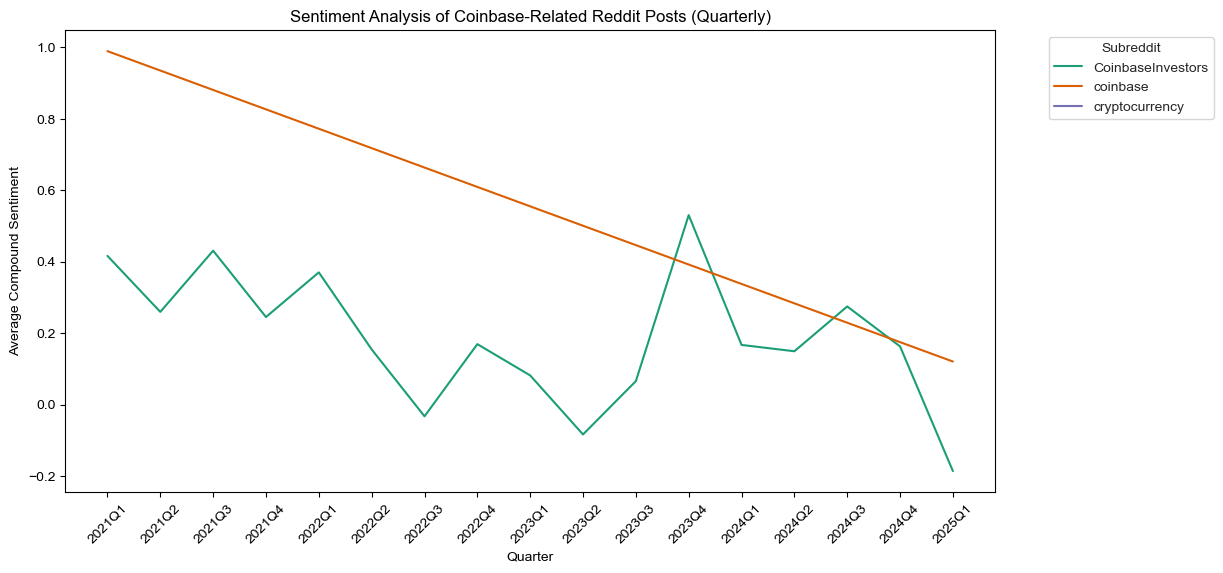

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("coinbase_reddit_sentiment.csv")

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create a 'quarter' column (format: "YYYY-QX")
df['quarter'] = df['date'].dt.to_period('Q')

# Group by quarter and subreddit, then compute mean sentiment
df_grouped = df.groupby(['quarter', 'subreddit'])['compound_sentiment'].mean().reset_index()

# Convert quarter to string for plotting
df_grouped['quarter'] = df_grouped['quarter'].astype(str)

# Plot sentiment trend over time by quarter
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Define a color palette
palette = list(sns.color_palette("Dark2", len(df_grouped['subreddit'].unique())))

# Plot each subreddit separately
for i, (series_name, series) in enumerate(df_grouped.groupby('subreddit')):
    plt.plot(series['quarter'], series['compound_sentiment'], label=series_name, color=palette[i])

# Format the plot
plt.xticks(rotation=45)
plt.xlabel("Quarter")
plt.ylabel("Average Compound Sentiment")
plt.title("Sentiment Analysis of Coinbase-Related Reddit Posts (Quarterly)")
plt.legend(title="Subreddit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [5]:
print(df['subreddit'].value_counts())

subreddit
coinbase             500
CoinbaseInvestors    358
cryptocurrency        11
Name: count, dtype: int64


In [6]:
import praw
import pandas as pd
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import time


reddit = praw.Reddit(
    client_id="7UGlu5JAAeduRsVzIamDag",
    client_secret="MqPgP6Ep6WHhYvQ10D6DPA7XPI6rlg",
    user_agent="MyRedditScraper/1.0 by missingsungjin",
    username="missingsungjin",
    password="Sungjin1!"
)

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define subreddits and keyword
subreddits = ["coinbase", "cryptocurrency", "CoinbaseInvestors"]
keyword = "coinbase"
years = range(2021, datetime.now().year + 1)

# Data storage
all_posts = []

# Scraping loop
for sub in subreddits:
    for year in years:
        try:
            print(f"Fetching 100 posts from r/{sub} for {year} ...")
            subreddit = reddit.subreddit(sub)

            posts = []
            for post in subreddit.top(time_filter="year", limit=1000):
                if keyword.lower() in post.title.lower() or keyword.lower() in post.selftext.lower():
                    text = post.title + " " + post.selftext
                    sentiment = analyzer.polarity_scores(text)

                    posts.append({
                        "subreddit": sub,
                        "title": post.title,
                        "upvotes": post.score,
                        "url": post.url,
                        "date": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        "year": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')[:4],
                        "compound_sentiment": sentiment["compound"],
                        "positive": sentiment["pos"],
                        "negative": sentiment["neg"],
                        "neutral": sentiment["neu"]
                    })

            posts = sorted(posts, key=lambda x: x["upvotes"], reverse=True)[:500]
            all_posts.extend(posts)

            print(f"Collected {len(posts)} posts from r/{sub} for {year}")

            time.sleep(2)

        except Exception as e:
            print(f"Error with r/{sub} for {year}: {e}")
            continue

# Save data to CSV
df = pd.DataFrame(all_posts)
df.to_csv("coinbase_reddit_sentiment.csv", index=False)

print("Data saved to coinbase_reddit_sentiment.csv")
df.head(50)

Fetching 100 posts from r/coinbase for 2021 ...
Collected 500 posts from r/coinbase for 2021
Fetching 100 posts from r/coinbase for 2022 ...
Collected 500 posts from r/coinbase for 2022
Fetching 100 posts from r/coinbase for 2023 ...
Collected 500 posts from r/coinbase for 2023
Fetching 100 posts from r/coinbase for 2024 ...
Collected 500 posts from r/coinbase for 2024
Fetching 100 posts from r/coinbase for 2025 ...
Collected 500 posts from r/coinbase for 2025
Fetching 100 posts from r/cryptocurrency for 2021 ...
Collected 36 posts from r/cryptocurrency for 2021
Fetching 100 posts from r/cryptocurrency for 2022 ...
Collected 36 posts from r/cryptocurrency for 2022
Fetching 100 posts from r/cryptocurrency for 2023 ...
Collected 36 posts from r/cryptocurrency for 2023
Fetching 100 posts from r/cryptocurrency for 2024 ...
Collected 36 posts from r/cryptocurrency for 2024
Fetching 100 posts from r/cryptocurrency for 2025 ...
Collected 36 posts from r/cryptocurrency for 2025
Fetching 100 po

,subreddit,title,upvotes,url,date,year,compound_sentiment,positive,negative,neutral
0,coinbase,"I got scammed out of 147,592$ worth of ETH",1302,https://www.reddit.com/r/CoinBase/comments/1hf...,2024-12-16 12:35:36,2024,0.8389,0.114,0.085,0.801
1,coinbase,See Trump coin on Coinbase turns my stomach.,1093,https://www.reddit.com/r/CoinBase/comments/1i6...,2025-01-21 22:31:18,2025,0.8720,0.230,0.034,0.736
2,coinbase,Got scammed on Coinbase and lost 41 ETH ($166k!),1067,https://www.reddit.com/r/CoinBase/comments/1hd...,2024-12-13 20:09:44,2024,-0.9928,0.084,0.114,0.803
3,coinbase,Coinbase balance $0.00,672,https://www.reddit.com/r/CoinBase/comments/1b2...,2024-02-28 17:25:15,2024,0.1406,0.095,0.063,0.843
4,coinbase,Let's Bring $PEP to Coinbase! 🚀,618,https://www.reddit.com/r/CoinBase/comments/1hb...,2024-12-11 12:50:08,2024,0.9940,0.216,0.005,0.779
5,coinbase,I STRONGLY suggest that you get rid of your as...,576,https://www.reddit.com/r/CoinBase/comments/1cq...,2024-05-12 20:43:10,2024,0.4506,0.117,0.109,0.774
6,coinbase,$20k Worth of Crypto Stolen Overnight,551,https://www.reddit.com/r/CoinBase/comments/1ho...,2024-12-28 14:16:04,2024,0.9017,0.087,0.050,0.863
7,coinbase,Coinbase pretty much stole my btc.,529,https://www.reddit.com/r/CoinBase/comments/1gy...,2024-11-23 14:37:08,2024,0.7963,0.106,0.091,0.804
8,coinbase,Account w/ 200k+ Still Locked. Setting Up A Cl...,486,https://www.reddit.com/r/CoinBase/comments/1d9...,2024-06-05 22:33:36,2024,-0.8259,0.037,0.099,0.865
9,coinbase,Fuck you Coinbase,471,https://www.reddit.com/r/CoinBase/comments/1i6...,2025-01-21 22:55:33,2025,-0.9129,0.093,0.339,0.568


In [7]:
print(df['year'].value_counts())

year
2024    2780
2025     385
Name: count, dtype: int64


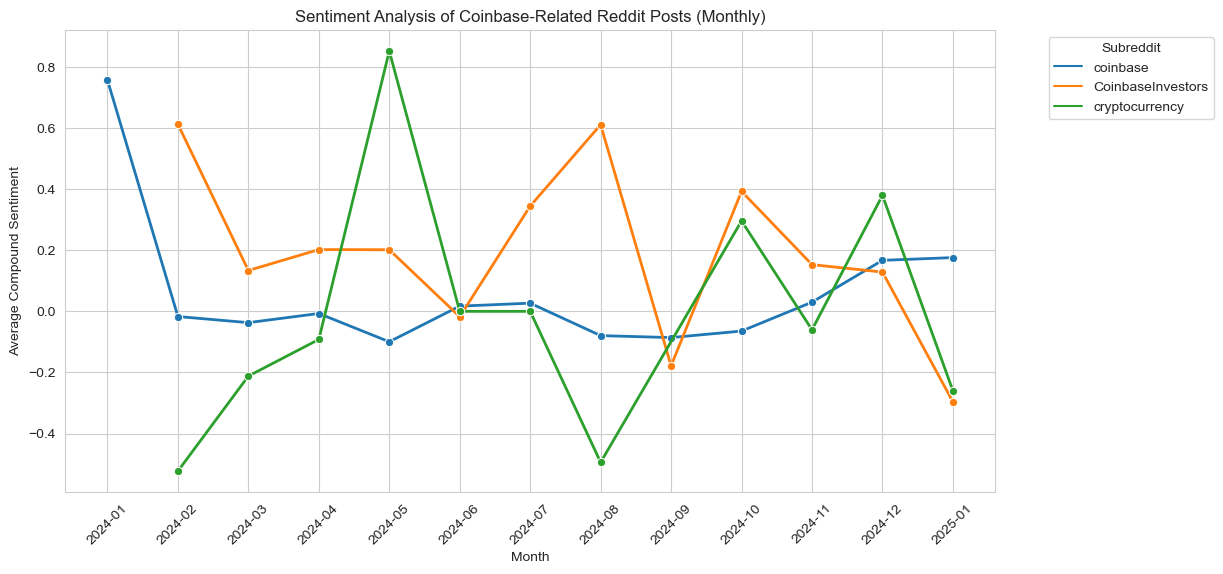

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess data
df = pd.read_csv("coinbase_reddit_sentiment.csv")
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M').astype(str)  # Convert Period to string

# Group by month and subreddit, then compute mean sentiment
df_grouped = df.groupby(['month', 'subreddit'])['compound_sentiment'].mean().reset_index()

# **Sort Data by Month**
df_grouped = df_grouped.sort_values(by="month")  # Ensures correct time ordering

# **Plot Scatter Points + Line Connecting Them**
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(
    data=df_grouped,
    x="month",
    y="compound_sentiment",
    hue="subreddit",  # Different lines for different subreddits
    marker="o",  # Adds scatter dots at each data point
    linewidth=2,  # Adjusts line thickness
    markersize=6  # Adjusts marker size
)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel("Month")
plt.ylabel("Average Compound Sentiment")
plt.title("Sentiment Analysis of Coinbase-Related Reddit Posts (Monthly)")
plt.legend(title="Subreddit", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [9]:
import pandas as pd
import praw
import nltk
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from bertopic import BERTopic

df = pd.read_csv("coinbase_reddit_sentiment.csv")

nltk.download("vader_lexicon")
analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return analyzer.polarity_scores(text)["compound"]

df["Sentiment"] = df["title"].apply(sentiment_analysis)

df["text"] = df["title"]

topic_model = BERTopic(language="english")

topics, probs = topic_model.fit_transform(df["text"])

df["BERTopic"] = topics

print(topic_model.get_topic_info())

df.to_csv("coinbase_reddit_with_topics.csv", index=False)
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

     Topic  Count                                             Name  \
0       -1    246                  -1_solana_help_welp_arbitration   
1        0     96                         0_xmas_tf_were_robinhood   
2        1     66                       1_wallet_vusdc_question_ny   
3        2     66                2_blocked_restricted_account_back   
4        3     58                             3_apology_use_app_an   
..     ...    ...                                              ...   
109    108     14          108_ashamed_rcoinbase_yourselves_should   
110    109     14                     109_exist_status_cronos_does   
111    110     13                       110_price_allowed_we_below   
112    111     13                      111_port_hackers_bug_hacked   
113    112     10  112_missing_successful_transactions_registering   

                                        Representation  \
0    [solana, help, welp, arbitration, yall, phishi...   
1    [xmas, tf, were, robinhood, said, did,

,subreddit,title,upvotes,url,date,year,compound_sentiment,positive,negative,neutral,Sentiment,text,BERTopic
0,coinbase,"I got scammed out of 147,592$ worth of ETH",1302,https://www.reddit.com/r/CoinBase/comments/1hf...,2024-12-16 12:35:36,2024,0.8389,0.114,0.085,0.801,0.2263,"I got scammed out of 147,592$ worth of ETH",44
1,coinbase,See Trump coin on Coinbase turns my stomach.,1093,https://www.reddit.com/r/CoinBase/comments/1i6...,2025-01-21 22:31:18,2025,0.8720,0.230,0.034,0.736,0.0000,See Trump coin on Coinbase turns my stomach.,33
2,coinbase,Got scammed on Coinbase and lost 41 ETH ($166k!),1067,https://www.reddit.com/r/CoinBase/comments/1hd...,2024-12-13 20:09:44,2024,-0.9928,0.084,0.114,0.803,-0.3802,Got scammed on Coinbase and lost 41 ETH ($166k!),44
3,coinbase,Coinbase balance $0.00,672,https://www.reddit.com/r/CoinBase/comments/1b2...,2024-02-28 17:25:15,2024,0.1406,0.095,0.063,0.843,0.0000,Coinbase balance $0.00,74
4,coinbase,Let's Bring $PEP to Coinbase! 🚀,618,https://www.reddit.com/r/CoinBase/comments/1hb...,2024-12-11 12:50:08,2024,0.9940,0.216,0.005,0.779,0.0000,Let's Bring $PEP to Coinbase! 🚀,86
